In [105]:
import pandas as pd
import math
from google.cloud import storage


In [117]:
client = storage.Client(project="uk-election-406413")
bucket = client.bucket("ukelectiondata")
files = bucket.list_blobs()
file_names = [file.name for file in files]


In [118]:
election_results = bucket.blob("full_df.csv")
election_results.download_to_filename('C:\\Users\\wg4618\\Documents\\LeWagon\\full_data.csv')


In [200]:
data = pd.read_csv('C:\\Users\\wg4618\\Documents\\LeWagon\\full_data.csv')
data.drop(data.columns[0], axis=1, inplace=True)
data.dropna(subset=['Cons_pre_GE_adjusted'], inplace=True)

data_raw = data[data['year'] != 2024].drop(columns="year")
data_new_raw = data[data['year'] == 2024].drop(columns="year")

data_raw[["child"]] = data_raw['0-9'] + data_raw['10-19']
data_raw[["young_adult"]] = data_raw['20-29'] + data_raw['30-39']
data_raw[["older_adult"]] = data_raw['40-49'] + data_raw['50-59']
data_raw[["retired"]] = data_raw['60-69'] + data_raw['70-79'] + data_raw['80+']

data_new_raw[["child"]] = data_new_raw['0-9'] + data_new_raw['10-19']
data_new_raw[["young_adult"]] = data_new_raw['20-29'] + data_new_raw['30-39']
data_new_raw[["older_adult"]] = data_new_raw['40-49'] + data_new_raw['50-59']
data_new_raw[["retired"]] = data_new_raw['60-69'] + data_new_raw['70-79'] + data_new_raw['80+']

X = data_raw[['Private_renters', 'Social_renters', 'Home_owners',
          #'0-9', '10-19',
          #'20-29', '30-39', '40-49', '50-59',
          #'60-69', '70-79', '80+',
          "child", "young_adult", "older_adult", "retired",
          'White', 'Asian', 'Black', 'Mixed', 'Other',
          'Cons_pre_GE_adjusted', 'Labs_pre_GE_adjusted', 'Libs_pre_GE_adjusted']]


X_new = data_new_raw[['Private_renters', 'Social_renters', 'Home_owners',
          #'0-9', '10-19',
          #'20-29', '30-39', '40-49', '50-59',
          #'60-69', '70-79', '80+',
          "child", "young_adult", "older_adult", "retired",
          'White', 'Asian', 'Black', 'Mixed', 'Other',
          'Cons_pre_GE_adjusted', 'Labs_pre_GE_adjusted','Libs_pre_GE_adjusted']]

y = data_raw[['conservative_votes', 'labour_votes', 'liberal_democrats_votes', 'other_parties_votes']]
y
#display(X_raw)


,conservative_votes,labour_votes,liberal_democrats_votes,other_parties_votes
0,4411.0,16073.0,5034.0,5440.0
1,3742.0,15416.0,1397.0,10968.0
2,5901.0,22662.0,599.0,4106.0
3,6518.0,17008.0,1072.0,7000.0
5,10734.0,7336.0,5786.0,6110.0
...,...,...,...,...
2858,13767.0,27312.0,4149.0,4277.0
2860,22912.0,9108.0,19224.0,2056.0
2861,26477.0,13348.0,6269.0,7809.0
2862,29356.0,21067.0,5910.0,1094.0


In [155]:
X.shape , X_new.shape


((2240, 17), (560, 17))

In [201]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

X.head(10)

X.shape , y.shape


((2240, 20), (2240, 4))

In [198]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data


,Variable,VIF
0,Private_renters,40.185778
1,Social_renters,17.317517
2,0-9,227.342475
3,10-19,317.276842
4,20-29,46.041871
5,30-39,145.208841
6,50-59,369.286910
7,60-69,274.334716
8,70-79,234.569432
9,80+,102.302276


In [164]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit a Linear Regression model
alphas = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100]}

ridge = Ridge()
grid_search = GridSearchCV(ridge, alphas, cv=5)
grid_search.fit(X_train, y_train)
display(grid_search.cv_results_['mean_test_score'])

#model = LinearRegression()
best_alpha = grid_search.best_params_['alpha']
display(best_alpha)

# Use the best alpha to fit the final Ridge model
final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the results
print("Coefficients:", final_model.coef_)
print("Intercept:", final_model.intercept_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


array([0.40274194, 0.40278163, 0.40304566, 0.40168364, 0.37478256,
       0.3281899 , 0.25093969, 0.07788783])

0.001

Coefficients: [[-1.94067423e+03 -5.19873258e+04 -1.49734923e+05 -5.50588479e+04
  -1.44986777e+05 -6.59602612e+04 -1.13059532e+05 -2.52145477e+05
   8.87503670e+04 -3.25541985e+04 -6.58055996e+03 -1.29293949e+04
   1.31577463e+05 -4.84622314e+04  2.50831641e+04 -1.04792138e+04]
 [-1.32460473e+04  1.68916571e+04  1.18549253e+05 -2.27752133e+04
   1.34846472e+05  1.20127660e+05  2.23879299e+05  1.54258013e+05
  -1.70917503e+02 -1.07261028e+05  2.07012953e+04  3.79492938e+04
  -1.05700741e+05 -6.54255821e+03  1.09271844e+04  8.92321747e+03]
 [ 2.79322416e+04 -1.87521229e+03 -2.87836874e+05  7.81761636e+04
  -1.53429365e+05 -6.90283832e+04 -2.08005444e+05 -1.40013900e+05
  -1.54889008e+05  9.83124135e+04 -5.80049814e+03 -2.18472468e+04
   8.77034855e+04 -2.23316402e+04 -5.23449302e+03  1.40569620e+04]
 [-3.63083534e+03 -2.72763542e+03  6.46542272e+04 -2.20545998e+04
   3.86620644e+04  9.81428057e+03  2.54686809e+04  6.58370854e+04
   1.30709306e+03  8.87694801e+01 -1.52198745e+03  6.916796

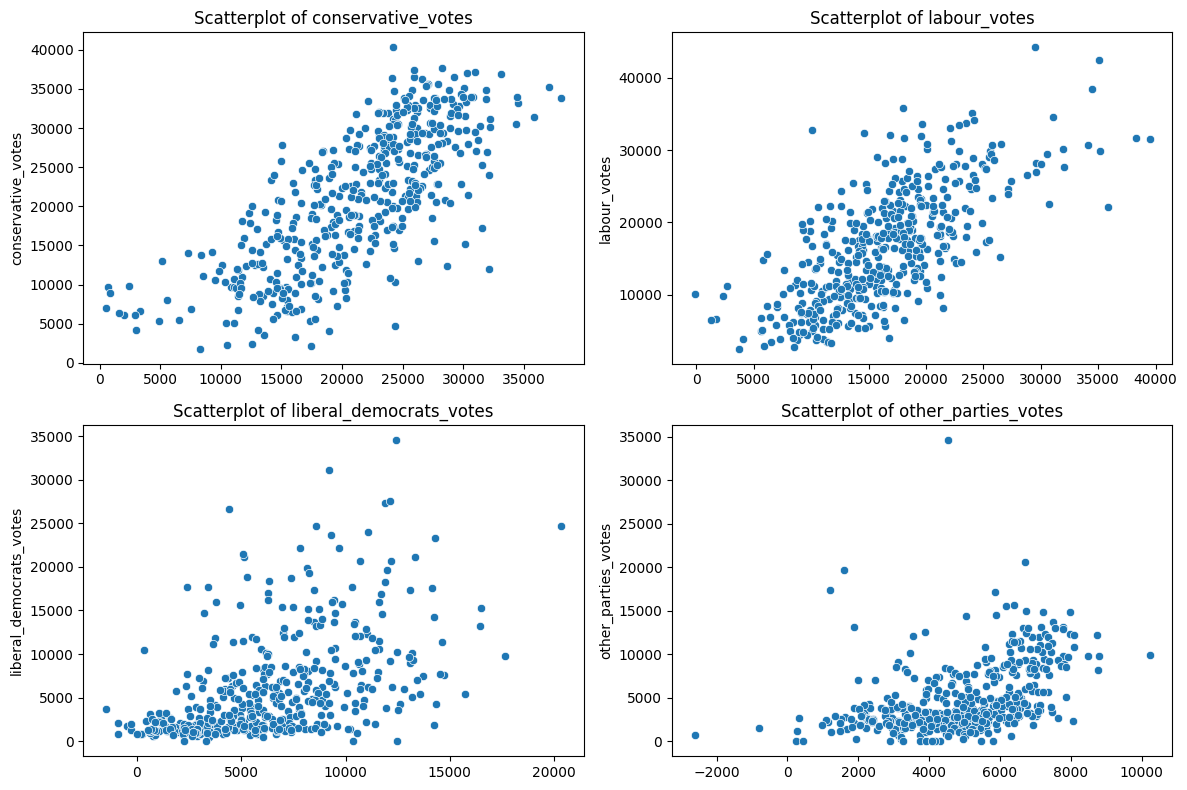

In [165]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over columns and create subplots
for i in range(4):
    sns.scatterplot(x=y_pred[:,i], y=y_test.iloc[:,i], ax=axes[i])
    axes[i].set_title(f'Scatterplot of {y_test.columns[i]}')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [173]:
import numpy as np
y_new = final_model.predict(X_new)
display(y_new)

unique_values, counts = np.unique(np.argmax(y_new, axis=1), return_counts=True)

frequency_table = pd.DataFrame({'Value': unique_values, 'Frequency': counts})

frequency_table


array([[17202.35368989, 19049.18688126,  6109.46241388,  4127.37803164],
       [23771.59314351, 11655.70549409,  9385.16618043,  3570.73061475],
       [19950.05748515, 20413.05373995,  6638.82253571,  3327.42404497],
       ...,
       [23757.47385222, 13326.57520454,  4709.11714016,  4627.41988132],
       [ 8484.93312284, 23731.27403633,  8724.17087511,  4845.81116598],
       [25481.14798393,  8209.81013287, 14155.61034454,  2849.19770037]])

,Value,Frequency
0,0,333
1,1,226
2,2,1
